# Finding Donors (Kaggle version)

This notebook details my work on the Kaggle competition for the "Finding Donors" project associated with Udacity's ML with PyTorch course. Many of the intial code was copied from the "finding_donors" notebook provided by the course for this assignment. 

This notebooks is structured as follows, mimicking how I performed my analysis:

- I loaded in the relevant data and performed preprocessing steps on both the original and Kaggle-specific dataset, including the removal of NaN values.
- Next, I designed and optimized a random forest model on the originial 'census.csv' dataset (with a 80/20 split for training/testing)
- Then, I designed and optimized a gradient boosting model on the originial 'census.csv' dataset (with a 80/20 split for training/testing). I spent more effort on optimizing this model, due to the expectation that gradient boosting was a better method than random forests.
- Finally, I ran my previously-trained model of this processed dataset and generated predictions, which were saved to a csv file for submission.

## Data processing

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import math
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset and test dataset
data = pd.read_csv("census.csv")
test_data = pd.read_csv("test_census.csv")

# Success - Display the last 20 records
display(data.tail(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45212,48,Private,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
45213,61,Private,HS-grad,9.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,48.0,United-States,<=50K
45214,31,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
45215,25,Private,HS-grad,9.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
45216,48,Local-gov,Masters,14.0,Divorced,Other-service,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


In [2]:
n_records = len(data)

n_greater_50k = data.income.value_counts()['>50K']

n_at_most_50k = data.income.value_counts()['<=50K']

greater_percent = n_greater_50k/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


### Data preprocessing

Here, I follow the preprocessiing steps suggested by the course's notebook. First, I log-transform capital gains/losses data given their skewed diistributions. Then, scaled the continuous variables using a MinMaxScaler. Finally, I performed One-HOT encoding on all categorical variables.

/Users/thomaslabar/Documents/Udacity_ML_with_PyTorch/finding_donors/visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


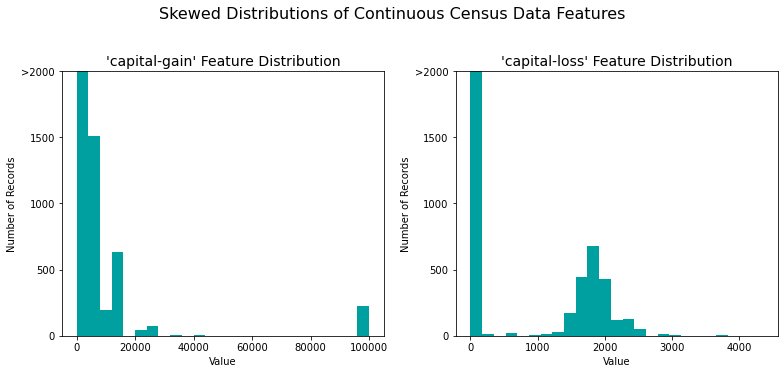

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

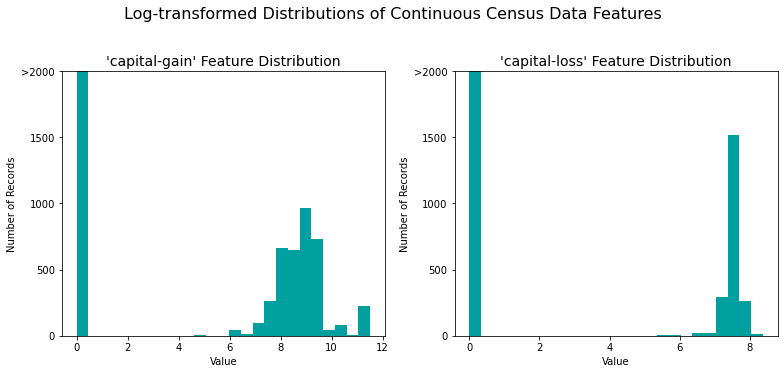

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [6]:
features_final = pd.get_dummies(features_log_minmax_transform)

income = income_raw.map({">50K": 1, "<=50K": 0})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

## Kaggle data preprocessing

Here, I will perform preprocessing on the 'test_census.csv' dataset to be able to apply my model trained above. First, I will look at the columns which have NaN values.

In [7]:
display(test_data.tail(n=5))

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
45217,45217,17.0,Private,11th,7.0,Never-married,Other-service,Own-child,White,Male,0.0,0.0,15.0,United-States
45218,45218,50.0,Federal-gov,Some-college,10.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,40.0,United-States
45219,45219,17.0,Self-emp-inc,12th,8.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,16.0,United-States
45220,45220,38.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688.0,0.0,40.0,United-States
45221,45221,22.0,Private,Some-college,10.0,Never-married,Farming-fishing,Own-child,White,Male,0.0,0.0,10.0,United-States


In [8]:
test_data = test_data.drop('Unnamed: 0',axis = 1)

In [9]:
test_data.isna().any()

age                True
workclass          True
education_level    True
education-num      True
marital-status     True
occupation         True
relationship       True
race               True
sex                True
capital-gain       True
capital-loss       True
hours-per-week     True
native-country     True
dtype: bool

In [10]:
print("Num. NaN's: "+str(len(test_data[test_data.isna().any(axis=1)])))
print("Percent Nan's: "+str(len(test_data[test_data.isna().any(axis=1)])/len(test_data)))

Num. NaN's: 230
Percent Nan's: 0.0050860200787227455


### Correcting NaN values

While less than 1% of rows have a NaN value, all columns have at least one. This means I need come up with a way to fix NaN entries for each column. Here, I will describe the process for each feature.


#### capital-gain/capital loss

Both these variables again showed skewed distributions, where 0 is the most common value, so I will set each NaN to 0 below.

/Users/thomaslabar/Documents/Udacity_ML_with_PyTorch/finding_donors/visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


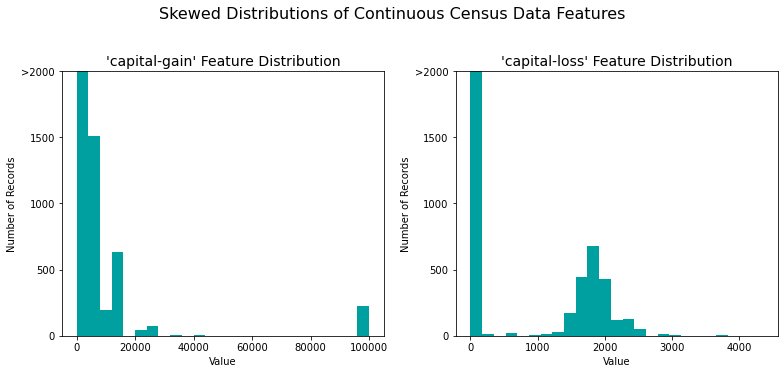

In [11]:
vs.distribution(test_data)

#### workclass/education_level/marital_status/occupation/relationship/race/sex/native-country

For this categorical variables, I will add a new category to each one called "Unknown." This new category will be added as a new feature once One-HOT encoding occurs after these corrections. Given the relative infrequency of individuals with any NaN values, I don't expect this to alter the results of anything, but it will allow the code to be run. It should be noted that some of these values could be inferred, like marital_status from relationship, but given the relative infrequency of these NaN values, I will not bother.

#### education_num

There is a 1:1 correspondance between education-level and education-num. Furthermore, there are no columns where both education-level and education-num are Nan. Therefore, I just need to convert each NaN in education-num to the correct education-level corresponding value.

In [12]:
print(test_data[test_data['education-num'].isna()])

        age   workclass education_level  education-num  \
7139   31.0     Private       Bachelors            NaN   
9203   52.0     Private       Bachelors            NaN   
12348  18.0     Private            10th            NaN   
16871  20.0     Private    Some-college            NaN   
17444  35.0     Private         HS-grad            NaN   
19675  44.0   State-gov         Masters            NaN   
21056  41.0     Private    Some-college            NaN   
22117  32.0     Private         HS-grad            NaN   
22472  40.0   Local-gov         HS-grad            NaN   
31033  43.0   Local-gov         Masters            NaN   
32790  47.0   State-gov         7th-8th            NaN   
37553  35.0     Private         HS-grad            NaN   
38175  19.0     Private         HS-grad            NaN   
39611  26.0     Private    Some-college            NaN   

               marital-status          occupation    relationship  \
7139       Married-civ-spouse     Exec-managerial         Hu

#### age/hours-per-week

Both are these are continuous variables and can be replaced by either the mean or the median of the dataset's distribution. The mean and median for age is 38.55 and 37, respectively. Meanwhile the mean and median for hours-per-week is 40.94 and 40, respectively. Given that both these variables are integers, I will replace NaN values to 37 and 40, respectively.

In [13]:
print("Age mean: "+str(np.mean([i for i in test_data.age if not math.isnan(i)])))
print("Age median: "+str(np.median([i for i in test_data.age if not math.isnan(i)])))
print(" ")
print("hours-per-week mean: "+str(np.mean([i for i in test_data["hours-per-week"] if not math.isnan(i)])))
print("hours-per-week median: "+str(np.median([i for i in test_data["hours-per-week"] if not math.isnan(i)])))

Age mean: 38.54998340891494
Age median: 37.0
 
hours-per-week mean: 40.939348359839855
hours-per-week median: 40.0


#### Below I do all the preprocessing described above

In [14]:
test_data_corrected = pd.DataFrame(data = test_data)

#capital-gain
test_data_corrected['capital-gain'] = test_data_corrected['capital-gain'].replace(np.nan,0.0)

#capital-loss
test_data_corrected['capital-loss'] = test_data_corrected['capital-loss'].replace(np.nan,0.0)

#workclass/education_level/marital_status/occupation/relationship/race/sex/native-country
for feature in ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']:
    test_data_corrected[feature] = test_data_corrected[feature].replace(np.nan,'Unknown')
    
#age
median_age = np.median([i for i in test_data['age'] if not math.isnan(i)])
test_data_corrected['age'] = test_data_corrected['age'].replace(np.nan,median_age)

#hours-per-week
median_hours = np.median([i for i in test_data['hours-per-week'] if not math.isnan(i)])
test_data_corrected['hours-per-week'] = test_data_corrected['hours-per-week'].replace(np.nan,median_hours)

#education_num (a really hacky solution based on there being a small number of rows that need changing)
level_num_dict = {' Bachelors':13.0,
                  " 10th":6.0,
                  " Some-college":10.0,
                  " HS-grad":9.0,
                  " Masters":14.0,
                  " 7th-8th":4.0}

for r in [7139,9203,12348,16871,17444,19675,21056,22117,22472,31033,32790,37553,38175,39611]:
    education_level = test_data_corrected.at[r,'education_level']
    new_value = level_num_dict[education_level]
    test_data_corrected.loc[test_data_corrected.index == r, 'education-num'] = new_value


In [15]:
test_data_corrected.isna().any()

age                False
workclass          False
education_level    False
education-num      False
marital-status     False
occupation         False
relationship       False
race               False
sex                False
capital-gain       False
capital-loss       False
hours-per-week     False
native-country     False
dtype: bool

### Further preprocessing

Now that all NaN values have been removed, I can perform the rest of the preprocessing steps I performed above for the traning dataset.

/Users/thomaslabar/Documents/Udacity_ML_with_PyTorch/finding_donors/visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


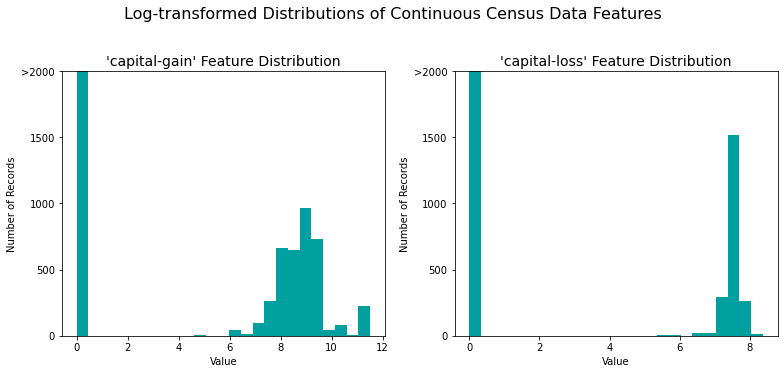

In [16]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
test_features_log_transformed = pd.DataFrame(data = test_data_corrected)
test_features_log_transformed[skewed] = test_data_corrected[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(test_features_log_transformed, transformed = True)

In [17]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

test_features_log_minmax_transform = pd.DataFrame(data = test_features_log_transformed)
test_features_log_minmax_transform[numerical] = scaler.fit_transform(test_features_log_transformed[numerical])


In [18]:
test_features_final = pd.get_dummies(test_features_log_minmax_transform)

# Print the number of features after one-hot encoding
test_encoded = list(test_features_final.columns)
print("{} total features after one-hot encoding.".format(len(test_encoded)))

# Uncomment the following line to see the encoded feature names
print(test_encoded)

111 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'workclass_Unknown', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'education_level_Unknown', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separ

#### Adding new features to training dataset

In order for my model to work on both datasets, I now will add the feature columns for the "Unknown" categories created during One-HOT encoding of the test dataset to the training dataset. I will do this by setting the value to 0 for all rows. Note: I forgot to do this originally and had to re-order my procedure here. Note2: The order of the columns must be the same in both cases.

In [31]:
new_columns = ['workclass_Unknown','education_level_Unknown','marital-status_Unknown','occupation_Unknown',
               'relationship_Unknown','race_Unknown','sex_Unknown','native-country_Unknown']

for nc in new_columns:
    features_final[nc] = [0 for i in range(len(features_final))]

features_final = features_final[test_features_final.columns]

In [32]:
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

111 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'workclass_Unknown', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'education_level_Unknown', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separ

## Training the model

### Spliting initial dataset into training and testing data

Before training my model, I performed the same training/testing split done in the original notebook

In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Training the model: Random Forest

The first model I decided to train was a Random Forest model. I trained both an unoptimized model and performed GridSearch to try to optimize the model. I used roc_auc_score as my scorer, as that is the metric the Kaggle competition is based on. I did not attempt to fully optimize this model, both due to lack of knowledge of the best procedure and learning that there was a greater chance that gradient boosting would be better performing.

In [22]:

#from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
#from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf_rf = RandomForestClassifier(random_state = 42)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters_rf = {'n_estimators':[160,320,480],
             'min_samples_split':[16,32,64],
             'min_samples_leaf':[1,2]}

# Make an fbeta_score scoring object using make_scorer()
#scorer = make_scorer(fbeta_score, beta=0.5)
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj_rf = GridSearchCV(clf_rf,param_grid = parameters_rf, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)

# Get the estimator
best_clf_rf = grid_fit_rf.best_estimator_

# Make predictions using the unoptimized and model
predictions_rf = (clf_rf.fit(X_train, y_train)).predict(X_test)
best_predictions_rf = best_clf_rf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_rf)))
print("ROC-AUC-Score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions_rf)))
print("\nOptimized Model\n------")
print("Final Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_rf)))
print("Final ROC-AUC-Score on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions_rf)))

Unoptimized model
------
Accuracy score on testing data: 0.8430
ROC-AUC-Score on testing data: 0.7741

Optimized Model
------
Final Accuracy score on the testing data: 0.8642
Final ROC-AUC-Score on the testing data: 0.7883


In [23]:
best_clf_rf

RandomForestClassifier(min_samples_split=32, n_estimators=320, random_state=42)

### Random Forest Conclusions

After optimization, I was able to improve the performance of the model's ROC-AUC from 0.7741 to 0.7883, which was a significant improvement, but I can probably do better.

### Training the model: Gradient Boosting

Next, I decided to train and optimize a gradient boosting model. I used a procedure detailed in [this blog post](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/). Here are the steps I took (it should be noted that only the final product remains in this notebook):

1. Explore N_estimators from 20 to 80, chaning learning rate until I got one around 50/60 (l_r = 1.05)
2. Fixing these values, explored max_depth = {1,5,10,15} and min_samples_split = {1,5,10,50,100,500,1000}
3. Further explored max_depth in {2,10} and min_samples_split = {500,1000,1500,2000}
4. Further explored max_depth in {2,10} and min_samples_split = {2000,3000,4000,5000}.
5. Set max_depth = 8 and min_samples_split = 4000
6. Explored min_samples_leaf in {30,70,10}
7. Picked min_samples_leaf = 40
8. Explore max_features in {7,20,2}
9. Explore max_features in {19,39,2}
10. Pick max_features = 23
11. Explore subsample in {0.5,0.55,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.0}
12. Keep subsample at default
13. Vary n_estimators/learning_rate in proportion: (120,0.52), (240,0.26), (360,0.26), (500,0.26).
14. (240,0.26) seemed the best

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the classifier
base_clf_gb = GradientBoostingClassifier(random_state = 42)

clf_gb = GradientBoostingClassifier(n_estimators = 240, learning_rate = 0.26 ,max_depth = 8, min_samples_split = 4000,
                                    min_samples_leaf = 40, max_features = 23,random_state = 42)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters_gb = {}

# Make an fbeta_score scoring object using make_scorer()
#scorer = make_scorer(fbeta_score, beta=0.5)
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj_gb = GridSearchCV(clf_gb,param_grid = parameters_gb, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_gb = grid_obj_gb.fit(X_train, y_train)

# Get the estimator
best_clf_gb = grid_fit_gb.best_estimator_

# Make predictions using the unoptimized and model
base_predictions_gb = (base_clf_gb.fit(X_train, y_train)).predict(X_test)
predictions_gb = (clf_gb.fit(X_train, y_train)).predict(X_test)
best_predictions_gb = best_clf_gb.predict(X_test)

# Report the before-and-afterscores
print("Base model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, base_predictions_gb)))
print("ROC-AUC-Score on testing data: {:.4f}".format(roc_auc_score(y_test, base_predictions_gb)))
print("\nUnoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_gb)))
print("ROC-AUC-Score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions_gb)))
print("\nOptimized Model\n------")
print("Final Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_gb)))
print("Final ROC-AUC-Score on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions_gb)))

Base model
------
Accuracy score on testing data: 0.8638
ROC-AUC-Score on testing data: 0.7805

Unoptimized model
------
Accuracy score on testing data: 0.8733
ROC-AUC-Score on testing data: 0.8053

Optimized Model
------
Final Accuracy score on the testing data: 0.8733
Final ROC-AUC-Score on the testing data: 0.8053


In [25]:
best_clf_gb

GradientBoostingClassifier(learning_rate=0.26, max_depth=8, max_features=23,
                           min_samples_leaf=40, min_samples_split=4000,
                           n_estimators=240, random_state=42)

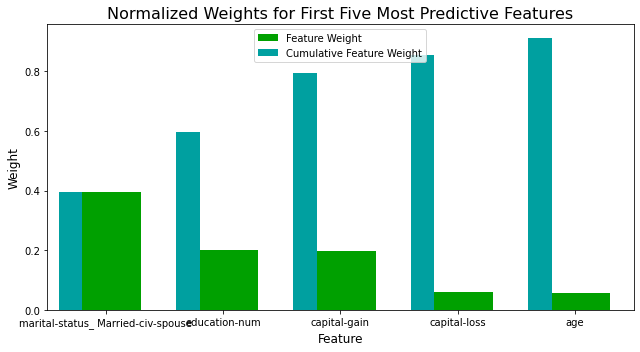

In [26]:
importances = base_clf_gb.feature_importances_
vs.feature_plot(importances, X_train, y_train)

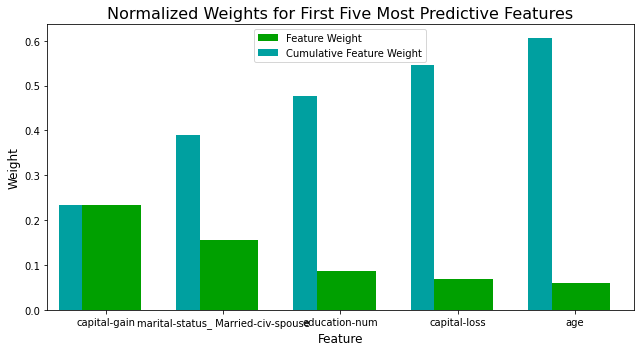

In [27]:
importances = best_clf_gb.feature_importances_
vs.feature_plot(importances, X_train, y_train)

### Gradient Boosting Conclusions

After optimizing, I was able to improve model performance from 0.7805 to 0.8053, which was a significant improvement both on the base model and on the random forest model. However, I was disappointed in the relative lack of improvement, and thought it would do better.

## Testing the model

Now, I can apply this trained model to the 'test_census.csv' dataset (after my corrections were performed, of course)

In [28]:
test_predictions = best_clf_gb.predict(test_features_final)

/Users/thomaslabar/anaconda2/envs/DSProjects/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


## Saving the model

Create dataframe from predictions save it to a csv for submission

In [45]:
submission_df = pd.DataFrame(data = {"id":range(len(test_predictions)),
                                     "income":test_predictions})

In [46]:
submission_df

,id,income
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
45217,45217,0
45218,45218,0
45219,45219,0
45220,45220,1


In [49]:
n_records = len(submission_df)

n_greater_50k = submission_df.income.value_counts()[1]

n_at_most_50k = submission_df.income.value_counts()[0]

greater_percent = n_greater_50k/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 3790
Individuals making at most $50,000: 41432
Percentage of individuals making more than $50,000: 0.08380876564504003%


In [47]:
submission_df.to_csv("submission_1.csv", index = False)